<h1>Неявные итерационные методы. Переобусловливатель.</h1>

Для начала зададим разреженную матрицу Пуассона. Её будет возвращать функция `poisson`

In [8]:
import numpy as np
from scipy import sparse as sp


def poisson(m: int):
    p = sp.diags([np.array([4 for _ in range(m ** 2)]), np.array([-1 for _ in range(m ** 2 - 1)]),
                  np.array([-1 for _ in range(m ** 2 - 1)])], (0, -1, 1)).toarray()
    for i in range(m ** 2):
        for j in range(m ** 2):
            if abs(i - j) == m:
                p[i, j] = -1
                break
    for i in range(1, m):
        p[i * m, i * m - 1] = 0
        p[i * m - 1, i * m] = 0
    return p.copy()

Зададим вектор случайных значений с помощью функции `get_f`

In [9]:
from random import random, seed


def get_f(n, a=0, b=1):
    seed()
    return np.array([a + b * (b - a) * random() for _ in range(n ** 2)])

Неявный итерационный метод Якоби (функция `jacoby`)

In [10]:
def jacoby(a: np.ndarray):
    return np.diag(np.diagonal(a))



Неявный итерационный метод Зейделя (функция `seidel`)

In [11]:
def seidel(a: np.ndarray):
    return np.triu(a)


Неявный итерационный попеременно треугольный метод (функция `triangular`)

In [12]:
def triangular(a: np.ndarray):
    ident = np.eye(len(a))
    w = 0.5
    r1 = np.tril(a)
    r2 = np.triu(a)
    for i in range(len(a)):
        r1[i, i] /= 2
        r2[i, i] /= 2
    print(ident)
    return np.dot(ident + (w * r1), ident + (w * r2))

Сам итерационный процесс представлен функцией `implicit`, которая возвращает массив погрешностей

In [13]:
from numpy import linalg as la


def implicit(n: int, v: np.ndarray, method: str):
    methods = {'jacoby': jacoby, 'seidel': seidel, 'triang': triangular}
    A = poisson(n)
    B = methods[method](A)
    D = np.dot(la.inv(B), A)
    g = np.dot(la.inv(B), v)
    x0 = np.zeros_like(g)
    x = x0
    r = np.dot(D, x) - g
    err = la.norm(r) / la.norm(g)
    Err = [err]
    eps = 1e-5
    k = 0
    while err > eps and k < 1000:
        tau = np.vdot(r, r) / np.vdot(np.dot(A, r), r)
        x = x - tau * r
        r = np.dot(D, x) - g
        err = la.norm(r) / la.norm(g)
        Err.append(err)
        k += 1
    return Err

Теперь построим графики зависимости погрешностей и номера итерации для каждого из методов

[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


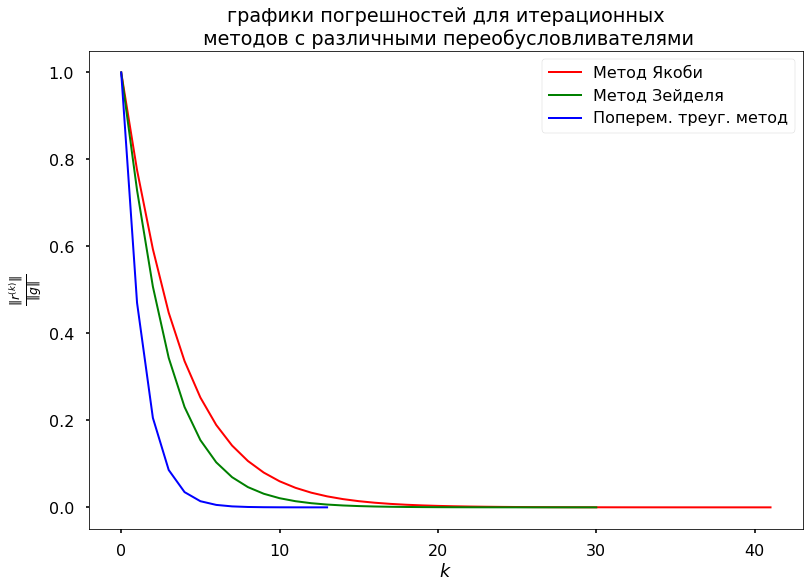

In [14]:
import matplotlib.pyplot as plt


f = get_f(7)
jcb = implicit(7, f, 'jacoby')
sdl = implicit(7, f, 'seidel')
trng = implicit(7, f, 'triang')
errs = [jcb, sdl, trng]

plt.style.use('seaborn-poster')

fig, ax = plt.subplots()
ax.plot([i for i in range(len(errs[0]))], errs[0], label='Метод Якоби', linewidth=2, color='red')
ax.plot([i for i in range(len(errs[1]))], errs[1], label='Метод Зейделя', linewidth=2, color='green')
ax.plot([i for i in range(len(errs[2]))], errs[2], label='Поперем. треуг. метод', linewidth=2, color='blue')
ax.set_ylabel('$\\frac{\Vert r^{(k)}\Vert}{\Vert g\Vert}$')
ax.set_xlabel('$k$')
ax.set_title("графики погрешностей для итерационных\n методов с различными переобусловливателями")
ax.legend()